In [1]:
import sys
import os
os.sys.path.append("/Users/itinawi/Library/Python/2.7/lib/python/site-packages")
# import the necessary packages
import cv2
import numpy as np
from PIL import Image, ImageFilter

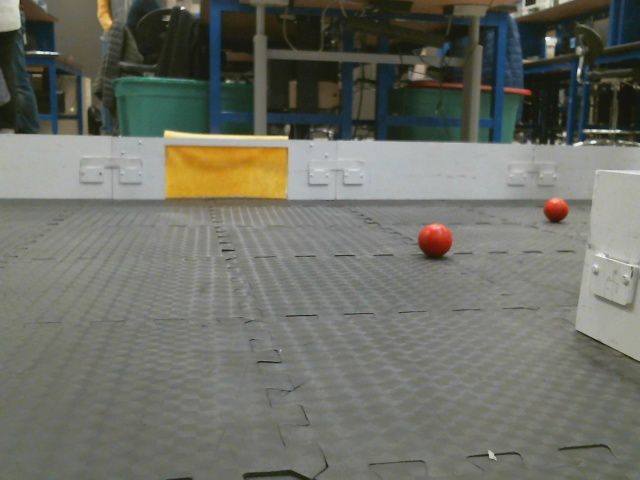

In [113]:
#raw_img = Image.open("/home/maslab/opencv/old_scripts/red_image.png")
raw_img = Image.open("/Users/itinawi/maslab/team-1/opencv/images/new_camera_angle/yellow_red.jpg")
# raw_img = Image.open("/Users/itinawi/maslab/team-1/opencv/images/new_red_two.jpg")
# raw_img = Image.open("/Users/itinawi/maslab/team-1/opencv/new_goals/red_goal_ball.jpg")
img = np.array(raw_img)
Image.fromarray(np.array(raw_img))

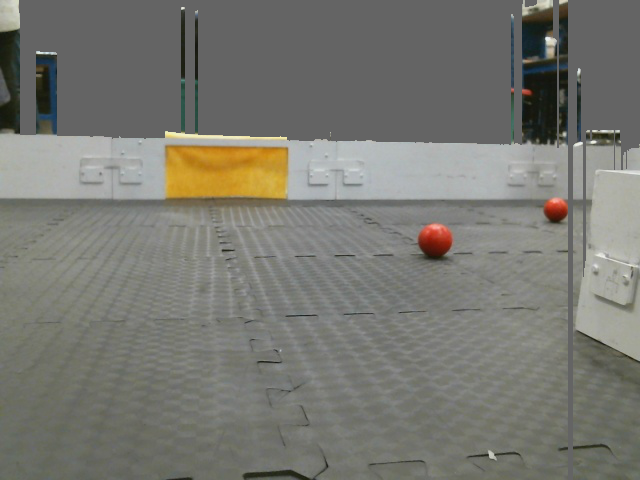

In [114]:
mask = (img[:,:,2] > 160) & (img[:,:,1] > 160) & (img[:,:,0] > 160)
new_im_arr = np.zeros(mask.shape)

wall_filter_mask = np.zeros(mask.shape)

# loop through the image column by column, look for the first white
# pixel, and blank everything before that
for j in range(mask.shape[1]):
    for i in range(mask.shape[0]):
        if not mask[i][j]:
            wall_filter_mask[i][j] = True
        else:
            break

np.place(img[:,:,0], wall_filter_mask, 100)
np.place(img[:,:,1], wall_filter_mask, 100)
np.place(img[:,:,2], wall_filter_mask, 100)

# uncomment if you want to view the image
Image.fromarray(img.astype(np.uint8))

In [115]:
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# # # define range of red color in HSV
# scale = 255
# lower_red = np.array([0, 0.4*scale, 0.4*scale])
# upper_red = np.array([0.1*scale, 0.6*scale, 0.6*scale])

# lower_blue = np.array([110,50,50])
# upper_blue = np.array([130,255,255])

# # # Threshold the HSV image to get only red colors
# mask = cv2.inRange(hsv, lower_blue, upper_blue)
# res = cv2.bitwise_and(img,img, mask= mask)
# # Image.fromarray(mask).show()
# img[:,:,1] = 0
# img[:,:,2] = 0
# np.place(img[:,:,0], mask, 255)
# np.place(img[:,:,0], 1-mask, 0)
# Image.fromarray(mask).show("mask")
# # Image.fromarray(img).show("img")
# # Image.fromarray(res).show("res")

def get_ball_mask(orig_img, hue_lower=120, hue_upper=160, blur_radius=5):
    img = orig_img.filter(ImageFilter.GaussianBlur(blur_radius))
    img = np.array(img.convert("HSV"))
    hue = img[:, :, 0]
    sat = img[:, :, 1]
    mask = (hue > 0) & (hue < 40) & (sat > 60) # RED
#     mask = (hue > hue_lower) & (hue < hue_upper) & (sat > 100)
    
    # don't return the mask anymore
    res = np.array(orig_img)
    np.place(res[:,:,0], 1-mask, 0)
    np.place(res[:,:,1], 1-mask, 0)
    np.place(res[:,:,2], 1-mask, 0)
    np.place(res[:,:,0], mask, 255)
    np.place(res[:,:,1], mask, 255)
    np.place(res[:,:,2], mask, 255)
    return Image.fromarray(res)

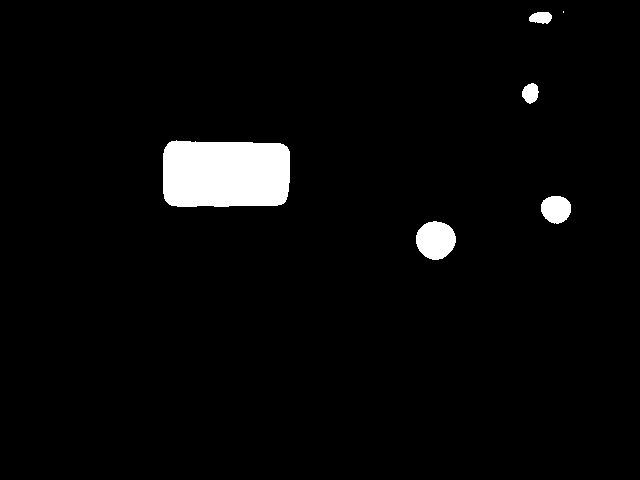

In [117]:
raw_img = np.array(raw_img)
ball_img = get_ball_mask(Image.fromarray(img))
ball_img = np.array(ball_img)[:,:,0]
Image.fromarray(ball_img)

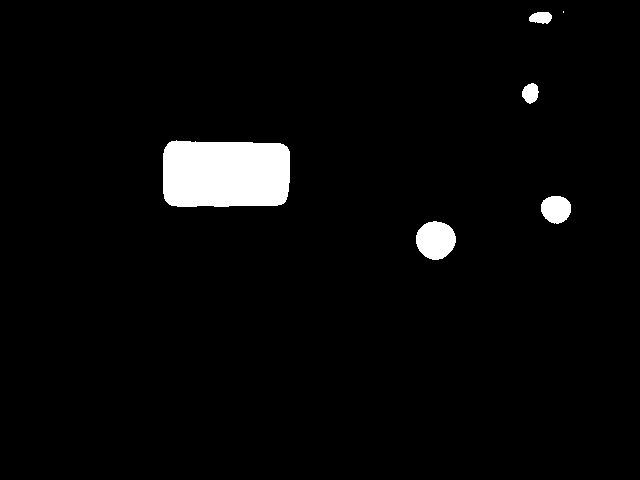

In [118]:
# flood fill algorithm for the balls
th, im_th = cv2.threshold(ball_img, 220, 255, cv2.THRESH_BINARY)
# im_th is white ball and black background
im_floodfill = im_th.copy()
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

cv2.floodFill(im_floodfill, mask, (0,0), 255)
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
im_out = im_th | im_floodfill_inv
# im_out = cv2.bitwise_not(im_out)
Image.fromarray(im_out)

In [119]:
#################################################################################################
# Set up the detector with custom parameters.
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
#params.minThreshold = 10
#params.maxThreshold = 200

# Filter by Area.
params.filterByArea = True
params.minArea = 500
params.maxArea = 10000 # 100,000 seems to work well

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.5
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.87

# Filter by Inertia
# params.filterByInertia = True
# params.minInertiaRatio = 0.01
params.filterByColor = True
params.blobColor = 255
# Create a detector with the parameters
# detector = cv2.SimpleBlobDetector(params)
# detector = cv2.SimpleBlobDetector()
is_cv3 = cv2.__version__.startswith("3.")
if is_cv3:
    detector = cv2.SimpleBlobDetector_create(params)
else:
    detector = cv2.SimpleBlobDetecto(params)

## detect 
kpts = detector.detect(img)


#################################################################################################
# Detect blobs.
print ball_img.shape
keypoints = detector.detect(im_out)
print "number of detected blobs ", len(keypoints)


# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im_out, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
Image.fromarray(im_with_keypoints).show()

(480, 640)
number of detected blobs  3
